In [1]:
import glob
import os
import datetime as dt

import numpy as np
import scipy.stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
import matplotlib as mpl
from netCDF4 import Dataset as ncopen
from cartopy.crs import NorthPolarStereo
from cartopy.feature import LAND, COASTLINE
from IPython.display import Image

from pynextsim import lib as nsl
from pynextsimf import get_logger

from pynextsim.openers import OpenerOsisafConc, OpenerNerscIceDrift
from pynextsim.nextsim_bin import NextsimBin
from pynextsimf.assimilation import AssimNerscDamage
from mod_netcdf_utils import nc_getinfo

import bamg

In [2]:
def get_drift_3files(f1, f2, f3):
    n1, n2, n3 = [NextsimBin(i) for i in [f1, f2, f3]]

    x1, y1 = n1.mesh_info.get_nodes_xy()
    i1 = n1.mesh_info.get_var('id')

    x2, y2 = n2.mesh_info.get_nodes_xy()
    i2 = n2.mesh_info.get_var('id')

    x3, y3 = n3.mesh_info.get_nodes_xy()
    i3 = n3.mesh_info.get_var('id')

    # indices of nodes common to 2 and 3
    ids_cmn_23, ids2i, ids3i = np.intersect1d(i2, i3, return_indices=True)

    # coordinates of nodes of common elements
    x2n = x2[ids2i]
    y2n = y2[ids2i]

    x3n = x3[ids3i]
    y3n = y3[ids3i]

    # indices of nodes common to 1 and 2 and 3
    ids_cmn_123, ids1i_123, ids2i_123 = np.intersect1d(i1, ids_cmn_23, return_indices=True)

    # coordinates of nodes of common elements
    x1n_123 = x1[ids1i_123]
    y1n_123 = y1[ids1i_123]

    x2n_123 = x2n[ids2i_123]
    y2n_123 = y2n[ids2i_123]

    x3n_123 = x3n[ids2i_123]
    y3n_123 = y3n[ids2i_123]

    print(x1.size, x2.size, x3.size, x1n_123.size)

    delta_t23 = (n2.datetime - n3.datetime).total_seconds()
    u23 = (x3n_123 - x2n_123) / delta_t23
    v23 = (y3n_123 - y2n_123) / delta_t23

    delta_t12 = (n1.datetime - n2.datetime).total_seconds()
    u12 = (x2n_123 - x1n_123) / delta_t12
    v12 = (y2n_123 - y1n_123) / delta_t12

    return x3n_123, y3n_123, u23, v23, u12, v12

def get_gridded_deformation(f1, f2, f3, xgrid, ygrid):
    x, y, u_0, v_0, u_1, v_1 = get_drift_3files(f1, f2, f3)
    e1_0, e2_0, e3_0, a, p, t = nsl.get_deformation_nodes(x, y, u_0, v_0)
    e1_1, e2_1, e3_1, a, p, t = nsl.get_deformation_nodes(x, y, u_1, v_1)

    # grid velocities (nodes)
    out_data = bamg.interpMeshToPoints(
        t.flatten()+1, x, y, 
        [u_0, v_0], 
        xgrid.flatten(), ygrid.flatten(), True, np.nan)
    # grid deformations (elements)
    out_data += bamg.interpMeshToPoints(
        t.flatten()+1, x, y, 
        [e1_0, e2_0, e1_1, e2_1], 
        xgrid.flatten(), ygrid.flatten(), True, np.nan)
    out_vars = ['u', 'v', 'e1_0', 'e2_0', 'e1_1', 'e2_1']
    return {j:np.array(i).reshape(xgrid.shape) for (i,j) in zip(out_data, out_vars)}
    
def get_gridded_vars(ifile, xgrid, ygrid):
    nvars = ['Damage', 'Concentration', 'Thickness']
    ovars = ['d', 'c', 'h']
    n = NextsimBin(ifile)
    d = n.get_gridded_vars(nvars, xgrid, ygrid)

    return {j:d[i] for (i,j) in zip(nvars, ovars)}

In [3]:
ndir = '/data2/antonk/shom5km_assim_none_bbm'

xgrid, ygrid = np.meshgrid(
    np.arange(-500000, 1000000, 3000),
    np.arange(400000, -800000, -3000))


In [4]:
ifiles = glob.glob(f'{ndir}/20200???/field_2*bin')
idates = []
gfiles = []
for ifile in ifiles:
    datestr = os.path.basename(ifile).split('_')[1].replace('Z.bin', '')
    timestr = datestr.split('T')[1]
    if timestr in ['000000', '060000', '120000', '180000']:
        idates.append(datestr)
        gfiles.append(ifile)

udates, udates_i = np.unique(idates, return_index=True)
ufiles = np.array(gfiles)[udates_i]
len(ufiles)
#udatesa = np.array([dt.datetime.strptime(i, '%Y%m%dT%H%M%S') for i in udates])
#udatesadiff = list(np.diff(udatesa))
#udatesadiff1 = [i.total_seconds() for i in udatesadiff]
#plt.plot(udatesadiff1)

1097

In [5]:
!rm /data2/antonk/shom5km_assim_none_bbm/*/*_4cnn.npz

In [ ]:
for fi in range(40, len(ufiles), 2):
    f1 = ufiles[fi-2]
    f2 = ufiles[fi-1]
    f3 = ufiles[fi]
    ofile = f3.replace('.bin', '_4cnn.npz')
    if os.path.exists(ofile):
        continue
    grid_defs = get_gridded_deformation(f1, f2, f3, xgrid, ygrid)
    grid_vars = get_gridded_vars(f3, xgrid, ygrid)
    for i in grid_defs:
        grid_defs[i][np.isnan(grid_vars['c'])] = np.nan
    grid_defs.update(grid_vars)
    print(ofile)
    np.savez(ofile, **grid_defs)


In [ ]:
!ls -lh /data2/antonk/shom5km_assim_none_bbm/*/*_4cnn.npz
!cp -v /data2/antonk/shom5km_assim_none_bbm/*/*_4cnn.npz /Data/sim/antonk/shom5km_defor_4cnn/
!chown :nersc /Data/sim/antonk/shom5km_defor_4cnn/ -R
!chmod g+r /Data/sim/antonk/shom5km_defor_4cnn/ -R

/data2/antonk/shom5km_assim_none_bbm/20200120/field_20200120T120000Z_4cnn.npz


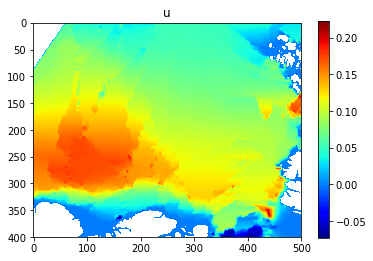

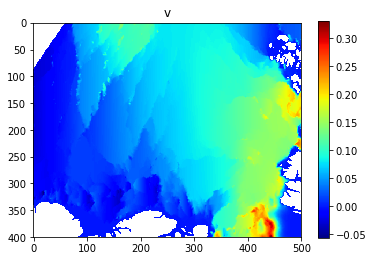

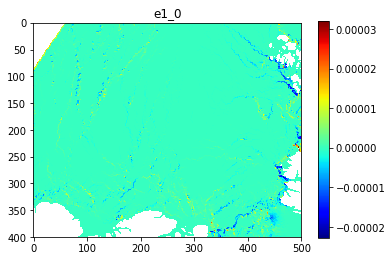

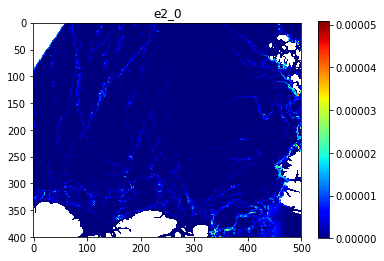

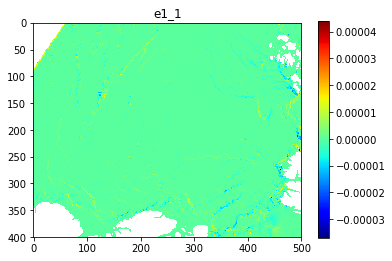

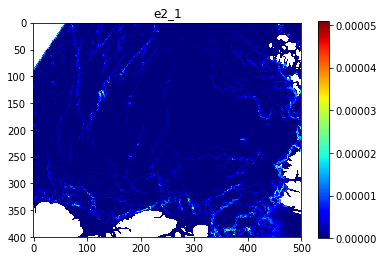

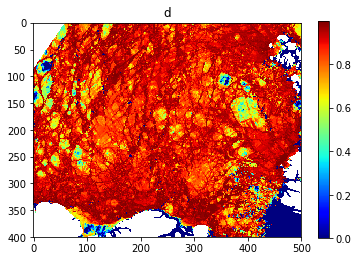

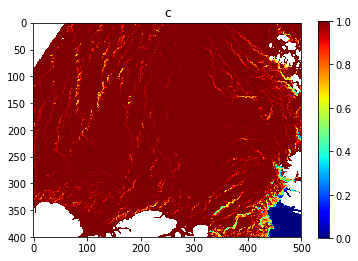

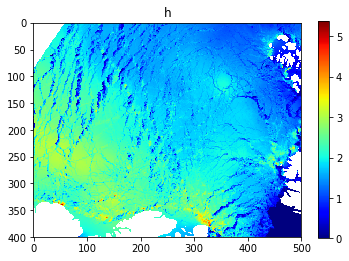

In [11]:
print(ofile)
d = np.load(ofile)

for i in d:
    plt.imshow(d[i], cmap='jet')
    plt.colorbar()
    plt.title(i)
    plt.show()